In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import seaborn as sns
from tqdm.notebook import tqdm
import copy

# Introduction

Welcome to the second lab of INF8801 !
In this lab, we are going to be looking at image inpainting by searching across a database. Note that there is an associated PDF problem statement.

In the first section, we will be looking at GIST descriptors. Having a source image, we will try to find it's semantically closest pair in a database.

In the DescGIST class, you are asked to complete the functions:
- `get_gabor` : which computes a single gabor filter
- `get_all_gabors` : which computes our entire set of gabor filters
- `describe` : which computes the response of an image to our set of gabor filters.

A few tests and displays are given to ensure you're on track.  In section 1.4., we will consider each image in the database, and you must find its closest pair. Don't forget to answer the questions !

---

The second section is independent of the first one. We suppose we have found a pair of images (src and target) and that our src image has a patch we want to inpaint. Your goal is to implement Poisson's method using Jacobi's algorithm (see pdf for links). 

Complete the function `poisson_blending`.

For each test in the data/testPoisson folder, we ask you to show:
- the src image
- the target image
- intermediate results of the algorithm
- your final image (i.e. the inpainted src image) and the corresponding iteration

---


Please rename the file with both or your last names.


# 1. GIST Descriptor

> **CODE :**
>
> Implement `get_gabor`, `get_all_gabors` and `describe` functions in the `DescGIST` class.

In [2]:
class DescGIST():
    def __init__(self):
        self.nb_orientations = 6    # Number of orientations of our filters
        self.nb_scales = 5          # Number of scales of our filters
        self.grid_size = 4          # Response of an image to our descriptor will be resiezd to a grid of size 4x4

        self.filter_size = 64       # Each filter will be of size filter_size x filter_size
        self.imsize=128             # Input images will be resized during description
        self.filters = np.zeros((self.filter_size, self.filter_size, self.nb_scales, self.nb_orientations)) #Where we will store our filter
        self.values = np.zeros((self.grid_size, self.grid_size, self.nb_scales, self.nb_orientations)) # Where we will store the response of an image to the descriptor


    def get_gabor(self, theta: float, lda: float, sigma_x: float, sigma_y: float) -> np.ndarray:
        """Returns a Gabor filter for the specified inputs
        Args:
            - theta (float): rotation angle in rads
            - lda (float): wave length (in pixels)
            - sigma_x (float): std of the gaussian in the direction of the wave
            - sigma_y (float): std of the gaussian perpendicular to the wave
        Returns:
            - filter (np.ndarray): Corresponding Gabor filter

        """

        # tile, duplique la structure du tableau et répète ses dimensions suivant un axe ou une dimension
        X = np.tile(np.linspace(-self.filter_size/2, self.filter_size/2, self.filter_size), (self.filter_size, 1))
        Y = X.copy().T

        ################################################################################################################
        ############################################ Complete the code !################################################
        ################################################################################################################

        # Calcule de la rotation des coordonnées
        x_prime = X * np.cos(theta) - Y * np.sin(theta)
        y_prime = X * np.sin(theta) + Y * np.cos(theta)

        # Filtre de Gabor : gaussienne x onde sinusoidale
        # Facteur de normalisation
        normalization = 1 / (2 * np.pi * sigma_x * sigma_y)

        # Exponentielles pour la gaussienne
        exp_x = np.exp(-0.5 * (x_prime**2 / sigma_x**2))
        exp_y = np.exp(-0.5 * (y_prime**2 / sigma_y**2))

        # Composante gaussienne
        gaussian = normalization * exp_x * exp_y

        sinusoid = np.sin(2 * np.pi * x_prime / lda)

        gabor_kernel = gaussian * sinusoid
        gabor_kernel *= -1 
        return gabor_kernel
        return gaussian * sinusoid
    

    def get_all_gabors(self) -> np.ndarray:
        """Computes a set of Gabor filters (4D np.array)
        Returns:
            - filters (np.ndarray): 4D array of filters, shape as shape self.filters
        """
        filters = np.zeros_like(self.filters) # Variable temporaire

        ################################################################################################################
        ############################################ Complete the code !################################################
        ################################################################################################################

        # Remplir le tableau filters avec les filtres Gabor pour chaque échelle et orientation
        for scale in range(self.nb_scales):  
            lda = self.filter_size / (2**(scale+1))  # Calcul de la longueur d'onde
            sigma_x = lda / 2                    # Écart-type en x
            sigma_y = lda                        # Écart-type en y
            for orientation in range(self.nb_orientations):
                # Calcul de l'angle en fonction de l'orientation
                theta = (self.nb_orientations-orientation) * np.pi / self.nb_orientations # Orientation ou direction

                # Calcule le filtre Gabor pour l'échelle et l'orientation actuelles
                filters[:, :, scale, orientation] = self.get_gabor(theta, lda, sigma_x, sigma_y)

        self.filters = filters
        return filters
    
    def display_filters(self) -> None:
        """Simple function for visualising your computed filters
        """
        filters = self.filters
        h,w,n,m = filters.shape
        s = np.zeros((h*n, w*m))
        for y in range(n):
            for x in range (m):
                filter = filters[:,:,y,x]
                filter = filter / np.max(np.abs(filter))

                s[y*w:(y+1)*w, x*h:(x+1)*h] = filter
        f = plt.gcf()
        plt.axis("off")
        plt.imshow(s, cmap='gray')
        return f

    def describe(self, image: np.ndarray) -> None:
        """Computes the response of an image to the filters stored in self.filters
        Args:
            - image (np.ndarray): 2D
        Returns:
            - None, stores in self.values the resized responses of an image to the self.filters
        """
        if len(image.shape) >= 3 and image.shape[-1] > 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        values = np.zeros_like(self.values)

        ################################################################################################################
        ############################################ Complete the code !################################################
        ################################################################################################################
        # Resize image to fixed size
        image_resized = cv2.resize(image, (self.imsize, self.imsize))
        image_resized = image_resized.astype(np.float32) / 255.0

        # Calcul des réponses aux filtres
        for scale in range (self.nb_scales):
            for orientation in range(self.nb_orientations):
                response = np.abs(scipy.ndimage.correlate(image_resized, self.filters[:, :, scale, orientation], mode='constant'))
                values[:,:, scale, orientation] = np.abs(
                    cv2.resize(response, (self.grid_size, self.grid_size)))

        
        # Stockage des réponses
        self.values = values

    def distance(self, d2: 'DescGIST') -> float:
        """Computes the distance between the object and another object of class descriptor
        Args:
            - d2 (DescGIST): Another descriptor object
        Returns:
            - distance (float): distance between self.values and d2.values
        """
        return np.linalg.norm(self.values - d2.values)

    def display(self) -> None:
        """
        A method for visualising the response of an image to our descriptor. 
        Recall that our response is a grid of size (grid_size x grid_size). 
        For each cell of that grid, we sum the response of the image for every scale and orientation. 
        We also flip twice (horizontally and vertically) the responses to account for symmetry.
        """
        if not np.any(self.values):
            print("Descriptor values haven't been computed")
            return False
        s = 256
        res = np.zeros((self.grid_size*s,self.grid_size*s))
        # Initialise diagram
        x = np.tile(np.linspace(-1, 1, s), (s, 1))
        y = x.copy().T

        theta = np.arctan2(y,x)
        r = np.sqrt(x**2 + y**2)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                diagram = np.zeros((s, s))

                for scale in range(self.nb_scales):
                    for orientation in range(self.nb_orientations):
                        frag = np.ones((s, s))
                        orientationValue = (orientation/self.nb_orientations) * np.pi
                        orientationDistance = np.min((np.abs(theta - orientationValue), np.abs(theta - orientationValue + 2*np.pi)), axis = 0)
                        frag[orientationDistance > 2*np.pi/self.nb_orientations] = 0
                        frag[r < 0.8*((scale/self.nb_scales)**0.7) +0.1] = 0
                        frag[r > 0.8*(((scale+1)/self.nb_scales)**0.7) +0.1] = 0

                        #symetry
                        frag += np.flip(np.flip(frag, 0), 1)
                        diagram += frag*self.values[i, j, scale, orientation]

                res[i*s:(i+1)*s, j*s: (j+1)*s] = diagram
        f = plt.gcf()
        plt.imshow(res)
        plt.axis("off")
        # f.savefig("display.png")
        return f



### 1.2. Visualizing the gabor filters

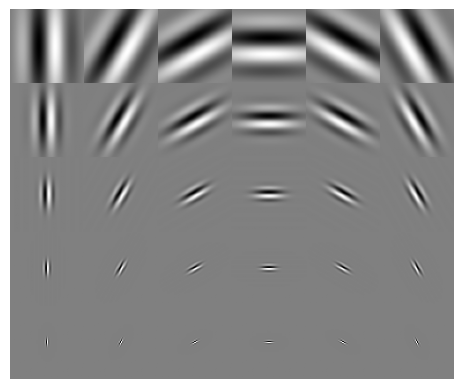

In [3]:
d =DescGIST()
d.get_all_gabors()
f = d.display_filters()
f.savefig("filters.png")

### 1.3. Visualizing the response of an image to our filters

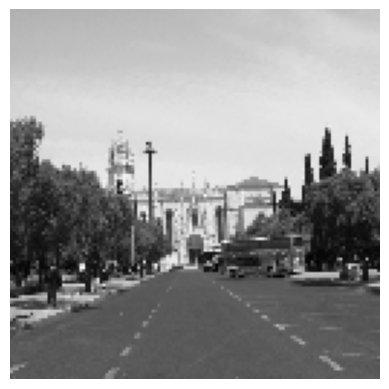

In [4]:
im = cv2.imread("./data/testGist/street.jpg")
grayscale = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), (128,128))
f = plt.gcf()
plt.imshow(grayscale, cmap='gray')
plt.axis("off")
f.savefig("grayscale.png", dpi=100)

#### Visualising a response to a single filter

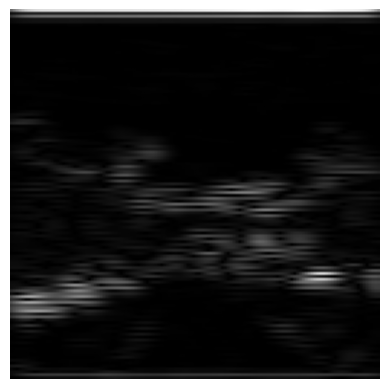

In [5]:
scale = 3
orientation = 3
grayscale = cv2.normalize(grayscale, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
response = np.abs(scipy.ndimage.correlate(grayscale, d.filters[:,:,scale, orientation], mode='constant'))
f = plt.gcf()
plt.imshow(response, cmap='gray')
plt.axis("off")
f.savefig("responseSIngleFilter.png", dpi=100)

#### Visualizing the response to all filters

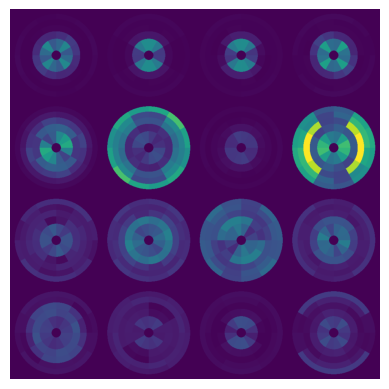

In [6]:
d.describe(grayscale)
res = d.display()
res.savefig("display.png")

> **QUESTION :**
>
>Why do we choose orientations inside `[0, Pi[` only? Why not cover the entirety of `[0, 2Pi[` ?

Les orientations sont choisies dans l'intervalle $[0, \pi[$ pour un filtre de Gabor plutôt que dans $[0, 2\pi[$, car l'onde sinusoidale est symétrique et périodique dans ce dernier intervalle.
- tout angle $\theta$ est alors équivalent à $\theta + \pi$ en termes de direction, mais de sens opposé et cette inversion n'apporte pas de nouvelle information pour la détection des motifs.
- On réduit ainsi le temps de calcul en réduisant le nombre de filtres nécessaires sans toutefois perdre les informations nécessaires et éviter la redondance.

> **QUESTION :**
>
>Why do we choose to resize the input image?

Nous choisissons de redimensionner les images pour éviter que la taille des images impactent sur les détections, ce qui permet de standardiser la taille des images pour le calcul des descripteurs et faciliter les comparaisons.

> **QUESTION :**
>
> Considering the resulting descriptor as seen above, is there any difference between using either a convolution or a correlation operation between the image and the filter? Briefly explain why or why not.

Bien que la convolution inverse le noyau du filtre avant de l'appliquer sur l'image, contraireemnt à la corrélation, il n'y a pas de différence entre les deux pour les filtres de Gabor parfaitement symétriques

### 1.4. Computing GIST descriptors on the whole database

In [7]:
def compare_images(data_path: str) -> np.ndarray:
    """Compares images and prints a seaborn array
    Args:
        - data_path (str): path to our images
    Returns:
        - distances (np.ndarray): 2D array of distances between images
    """
    objects = os.listdir(data_path)
    objects_names = [x.split('.')[0] for x in objects]
    objects_names.sort()
    descriptors = []

    print("Generating descriptors")
    for obj, name in tqdm(zip(objects, objects_names)):
        image = cv2.imread(os.path.join(data_path, obj))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        descriptor = DescGIST()
        descriptor.get_all_gabors()
        descriptor.describe(image)
        descriptors.append(descriptor)
    print("Computing distances")
    n = len(descriptors)
    distances = np.zeros((n,n))
    for i, d1 in tqdm(enumerate(descriptors)):
        for j in range(i, n):
            dist = d1.distance(descriptors[j])
            distances[i,j] = dist
            distances[j,i] = dist

    sns.heatmap(distances, xticklabels=objects_names, yticklabels=objects_names)
    return distances

Generating descriptors


0it [00:00, ?it/s]

Computing distances


0it [00:00, ?it/s]

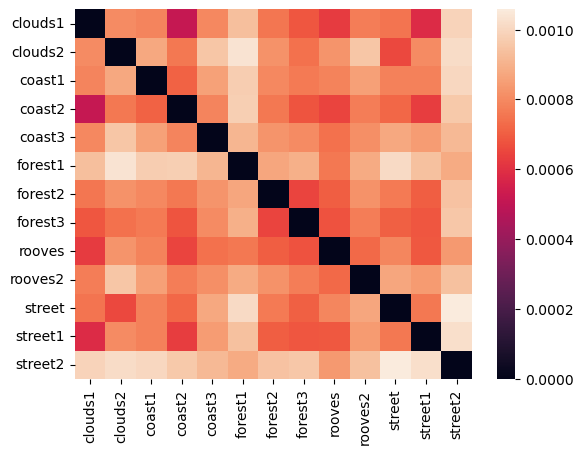

In [8]:
distances = compare_images('./data/testGist/')

>**QUESTION :**
> 1. Interpret the heatmap. (5-10 lines)
> 2. For each image, what would be the closest image according to GIST descriptors? Is that semantically consistent?

1. Interprétation de la carte de chaleur

La carte de chaleur ici s'apparente ici à une matrice de corrélation représentant une matrice de distances entre les descripteurs des images.

Une valeur faible indique que la similarité est forte entre deux images alors qu'une valeur élevée indiaue que la différance de distance est très grande entre deux images.
- Les zones sombres sont les valeurs proches de 0 et montrent les images ayant des descripteurs GIST similaires
- Les valeurs élevées ou zones claires montrent des images très différentes selon le descripteur GIST
- Pour un changement progressif de couleur tel qu'indiqué entre noir et blanc établit une transition entre catégories similaires


2. L'image la plus proche de l'autre est celle qui possède la plus petite valeur de distance.
- Pour un descripteur GIST bien conçu, les images les plus similaires devraient être visuellement et sémantiquement proches.
- Par contre, puisqu'il analyse que la texture globale et la structure il peut se tromper sur des objets de même forme mais de classes différentes.

### Finding the closest image to another image

In [9]:
objects = os.listdir("./data/testGist")
objects_names = [x.split('.')[0] for x in objects]
for i in range (len(distances)):
    obj = objects_names[i]
    dist = distances[i, :]
    dist[i] = np.inf
    match = np.argmin(dist)
    print(obj, "<->", objects_names[match])

coast2 <-> coast1
clouds2 <-> clouds1
street <-> coast1
coast1 <-> coast2
street2 <-> forest3
forest1 <-> forest3
rooves <-> rooves2
rooves2 <-> rooves
forest3 <-> coast2
street1 <-> forest3
clouds1 <-> clouds2
coast3 <-> coast2
forest2 <-> forest3


# 2. Poisson Blending

The function below could be useful to you. It computes the correlation of a 2D filter on an image that can have one or more channels.
If the variable "image" is an RGB image for example, the 2D kernel is passed along each channel independntly, and returns the correlated RGB image.
See `scipy.ndimage.correlate` for more information

In [10]:
def correlate(image: np.ndarray, kernel: np.ndarray, mode: str) -> np.ndarray:
    """Correlates an image with a kernel
    Args:
        - image (np.ndarray): the RGB image on which we perform correlation
        - kernel (np.ndarray): the correlation kernel
        - mode (str): the mode for the correlation
    Returns:
        - result (np.ndarray): the result of the correlation
    """
    result = np.empty_like(image)
    if len(image.shape) == 2:
        nChannels = 1
    else:
        nChannels = np.min(image.shape)
    for channel in range(nChannels):
        result[:, :, channel] = scipy.ndimage.correlate(image[:,:,channel], kernel, mode=mode)

    return result

###  2.1. Preparing data

In [11]:
# SRC image is a png. It has a fourth channel called transparency. To get the 4D image, we load it using cv2.IMREAD_UNCHANGED
# We then extract the src image (BGR that we convert to RGB) and the transparency as two separate arrays
src = cv2.imread("./data/testPoisson/test2/src.png", cv2.IMREAD_UNCHANGED)
transparency = src[:,:,3]
src = src[:,:,:3]
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

# We extract the target array and convert it to RGB
target = cv2.imread("./data/testPoisson/test2/target.png")
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

# Having access to the transparency gives us access to the pixels that have been shaded in our soruce image, vs the pixels that we want to keep intact. The latter will be stored in fixed_areas
transparency = transparency / np.max(transparency)
fixed_areas = transparency>0.5

# We scale our images to [0,1]
src = src /255
target = target /255

### 2.2. Implementing Jacobi's method

The Poisson blending problem can be described as such : 

"The laplacian of the target is equal to the divergence of the source, where the transparency = 0."

To solve this problem (since we don't know the value of the divergence of the blended source), we use an algorithm called Jacobi's method, which converges towards a solution to the equation. Iteratively update the source image in this way : 

"The value of every non-fixed pixel in the source image is equal to the mean value of it's neighbors + laplacian of the target."

Locking strict boundaries for the part of the image we wish to inpaint will allow us to iteratively propagate the appropriate values of the divergence of the source. *Thus, make sure to modifiy only the non-fixed pixels of the source image.*

Note : You can modify the signature of the function `poisson_blending()` to return multiple outputs and/or take different inputs if you wish to. Just make sure that you are able to plot what we ask for and know the final iteration of your algorithm.

> **CODE :**
>
> Implement the `poisson_blending` function.

In [12]:
def poisson_blending(src: np.ndarray, target: np.ndarray, fixed_areas: np.ndarray, nb_iter: int) -> np.ndarray:
    """
    This function computes the blended image between the src and target images, 
    only in the ROI specified in the fixed_areas logical image.

    Hint : use the correlate function above to apply a kernel to an image
    Hint : use the kernels defined below to compute the mean values of the 
           neighboring pixels (divergence kernel) and the laplacian of an image (laplacian kernel)
    Hint : make sure that you are working in a copy of the src image and not the src image itself 

    You need to : 
    - Compute the laplacian of the target
    - Iteratively modify the src image, only in the non fixed areas, using Jacobi's method
    - Plot the blended image (not each iteration but at a fixed step) 


    Args:
        - src (np.ndarray): the RGB image in which we want to do the inpainting
        - target (np.ndarray): the 3D image that we want to add into the src image
        - fixed_areas (np.ndarray): a binary image (mask) that represents the pixels to inpaint
        - nb_iter (int): int, a number of iterations to run
    
    Returns:
        - result (np.ndarray) : the blended image

    """
    # Initialize divergence kernel and laplacian kernel
    div_kernel = np.array([[0,1,0],
                      [1,0,1],
                      [0,1,0]])
    lap_kernel = np.array([[0,-0.25,0],
                      [-0.25,1,-0.25],
                      [0,-0.25,0]])

    ################################################################################################################
    ############################################ Complete the code !################################################
    ################################################################################################################
    # Compute the laplacian of the target
    laplacian_target = correlate(target, lap_kernel, mode='reflect')
    
    # Copy source image to avoid modifying it directly
    blended = src.copy()
    
    # Initialize stopping criterion parameters
    tolerance = 1e-5
    prev_blended = np.zeros_like(blended)
    
    for i in range(nb_iter):

        # Compute the mean of neighboring pixels (divergence)
        mean_neighbors = correlate(blended, div_kernel, mode='reflect') / 4.0
        
        # Update only non-fixed pixels using Jacobi's method
        blended[~fixed_areas] = mean_neighbors[~fixed_areas] + laplacian_target[~fixed_areas]
        
        # Compute sum of absolute differences (SAD) for convergence check
        sad = np.sum(np.abs(blended - prev_blended))
        #print(f"Iteration {i+1}: SAD = {sad}")
        if sad < tolerance:
            print(f"Convergence reached after {i+1} iterations.")
            break
        prev_blended = blended.copy()
    
    return blended

### 2.3. Displaying results

> **QUESTION :**
> 
> For each test in the data/testPoisson folder, we ask you to show:
> - The source image
> - The target image
> - Some intermediate results of the algorithm
> - Your final image (i.e. the inpainted src image) and the corresponding iteration you find acceptable.
>
> Beware, for images with larger regions to inpaint, the algorithm can take many iterations to converge. If you do not like the trial-and-error approach of setting a max number of iterations, you are encouraged to implement a stopping criterion as mentioned in the next question (although it is optional).


In [13]:
iteration_values : list[int] = [250, 500, 750, 1000] # À modifier selon la convenance

def test(test_directory: str):
    # Récupérer tous les sous-dossiers dans le répertoire de test
    test_dirs = [os.path.join(test_directory, d) for d in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, d))]

    for test_dir in test_dirs:
        # Charger l'image source avec transparence
        src = cv2.imread(os.path.join(test_dir, "src.png"), cv2.IMREAD_UNCHANGED)
        transparency = src[:, :, 3]
        src = src[:, :, :3]
        src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

        # Charger l'image cible
        target = cv2.imread(os.path.join(test_dir, "target.png"))
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        # Créer le masque des zones fixes à partir de la transparence
        transparency = transparency / np.max(transparency)
        fixed_areas = transparency > 0.5

        # Normaliser les images
        src = src / 255.0
        target = target / 255.0

        # Création de la figure pour afficher toutes les images sur une seule ligne
        fig, axes = plt.subplots(1, len(iteration_values) + 2, figsize=(20, 5))

        # Affichage de l'image source
        axes[0].imshow(src)
        axes[0].axis("off")
        axes[0].set_title(f"Source\n{os.path.basename(test_dir)}")

        # Affichage de l'image cible
        axes[1].imshow(target)
        axes[1].axis("off")
        axes[1].set_title("Target")

        # Affichage des résultats pour chaque nombre d'itérations
        for i, nb_iter in enumerate(iteration_values):
            blended = poisson_blending(src, target, fixed_areas, nb_iter)
            axes[i + 2].imshow(blended)
            axes[i + 2].axis("off")
            axes[i + 2].set_title(f"{nb_iter} iterations")

        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5014935183497838..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3833542072271949..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35965921551532926..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34352513666547463..0.9921568627450981].


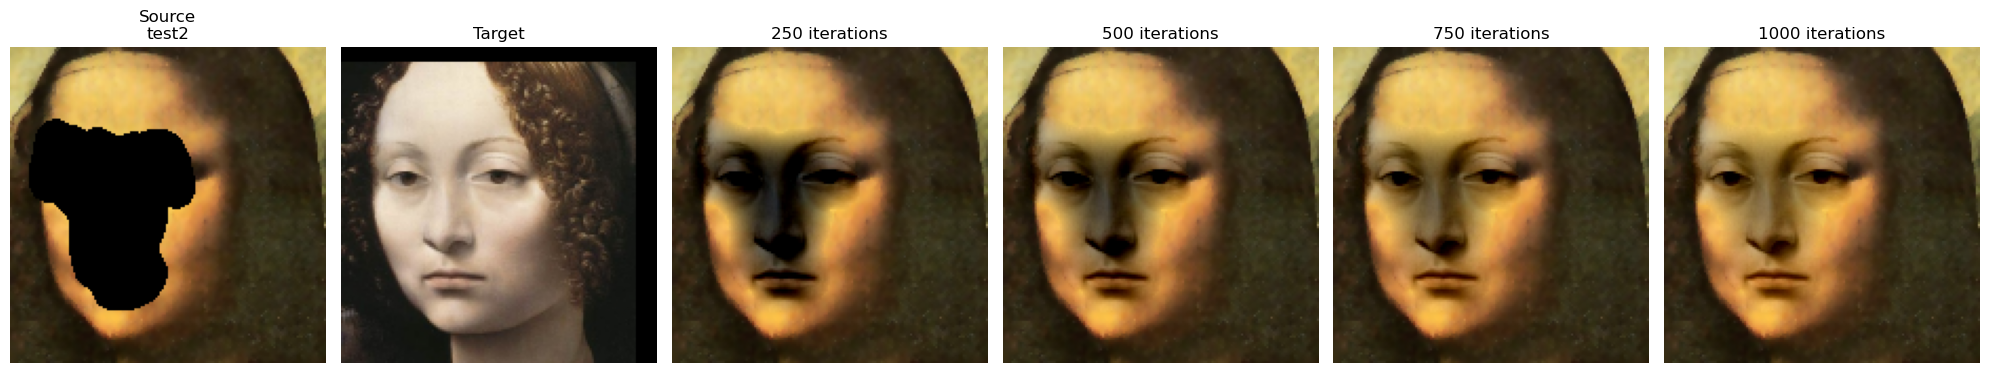

Convergence reached after 278 iterations.
Convergence reached after 278 iterations.
Convergence reached after 278 iterations.


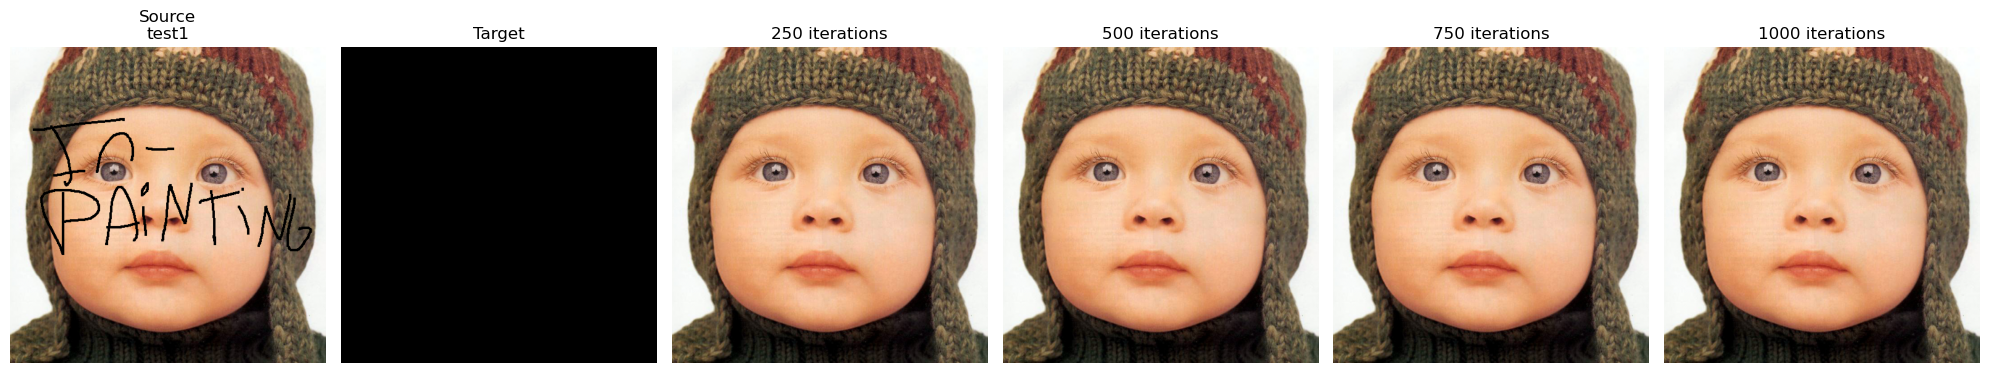

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6315903316525521..1.0179735018881941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6223742915066575..1.0552338543894586].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6009568105877074..1.0712063587928458].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5799824903377453..1.0802516377671534].


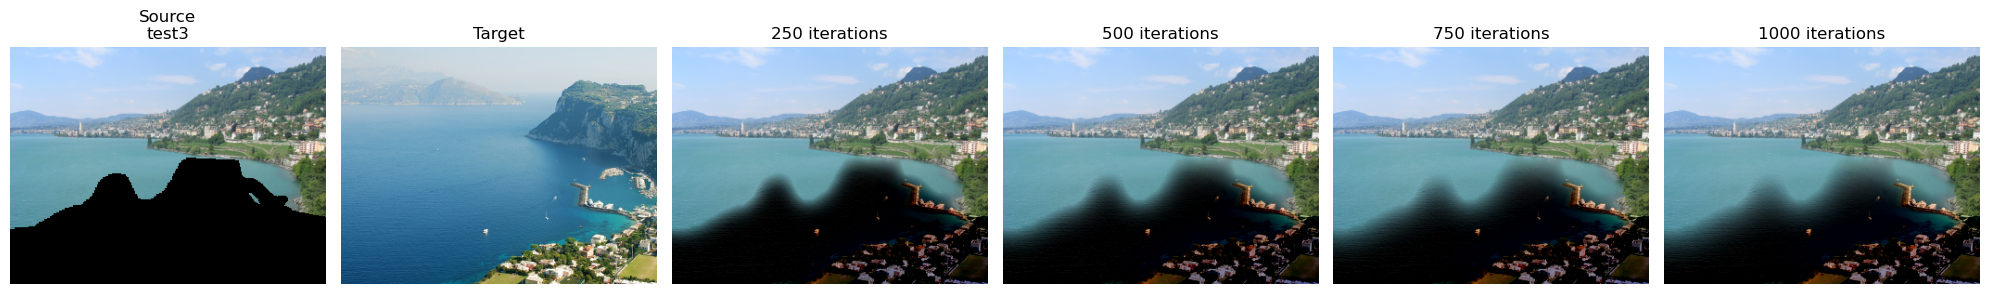

In [14]:
test("./data/testPoisson")

> **QUESTION :**
>
> Clearly, only one value for the maximum number of iterations cannot suit all images. Think of a way to stop the algorithm automatically. Give some details about how you would implement it. (Open question)

Une façon d'arrêter l'algorithme automatiquement serait d'utiliser l'entropie de l'image qui cacule la quantité d'information qu'elle contient. Concrètement c'est l’entropie de sa fonction de densité de probabilité (histogramme normalisée). Sachant que pendant les itérations l'image source à reconstruire ou à remplir se rapproche de la cible, on peut observer la variation d'entropie entre deux itérations et arrêter lorsque cette différence est faible. Cependant le critère d'arrêt d'erreur pour la convergence serait aussi un problème quant à sa fixation.

Par formule
Critère d’Arrêt Proposé :  
`|entropie(i) - entropie(i-1)| < tolerance`

On pourrait également ajouter un compteur `patience` pour éviter de s'arrêter trop vite. On attend que cette condition soit vérifiée pendant un certains nombres d'itérations pour éviter de petites fluctuations et de s'assurer de la stabilité de la convergence.